# Imports

In [1]:
import sqlite3 as sql
import os
import numpy as np
import matplotlib.pyplot as plt
import math

# Funções

## BASE_DADOS

In [2]:
def BASE_DADOS(nome_bd):                 
    
    if os.path.isfile(nome_bd):
        os.remove(nome_bd)
        
    bd = sql.connect(nome_bd)
    return bd

## CRIAR TABELAS

In [3]:
def CRIAR_TABELAS(bd):
    tabela_composto(bd)
    tabela_atributos(bd)   
    
def tabela_composto(bd):
    com='CREATE TABLE Compostos (\
        identificador INTEGER,\
        nome TEXT,\
        formula_quimica TEXT,\
        ponto_de_ebulicao FLOAT);'
    bd.execute(com)
    
def tabela_atributos(bd):
    com='CREATE TABLE Atributos (\
        identificador INTEGER,\
        atributos TEXT);'
    bd.execute(com)

## CARREGAR

In [4]:
def CARREGAR(bd, ficheiro):

    for line_file in ficheiro:
        id_composto, nome, formula, ebulicao, atributos = line_file.split(";")
       
        comando1 = 'INSERT INTO Compostos VALUES ('\
            +'"' + id_composto + '",'\
            +'"' + nome + '",'\
            +'"' + formula + '",'\
            +'"' + ebulicao + '");'

        bd.execute(comando1)

        comando2 = 'INSERT INTO Atributos VALUES ('\
            +'"' + id_composto + '",'\
            +'"' + atributos[:-1] + '");'

        bd.execute(comando2)
    
    ficheiro.close()

## REPORT

In [5]:
def REPORT(nome_ficheiro):
    open(nome_ficheiro, "a+")

## LIST

In [6]:
def LIST(bd, ultimo_report_criado, linha):
    
    #extrai da linha
    comando, formula, atributos = linha.split(" ")

    #Acessa o BD e seleciona todos os compostos com o atributo requisitado na linha
    dict_compostos = select_compostosXformula(bd, atributos)
     
    # Filtrar os compostos que tem a mesma formula requisitada na linha
    resultados = filtra_compostos(dict_compostos,formula)
                
    # Salva dentro do ultimo report criado
    salve_in_report(ultimo_report_criado, linha, resultados)   

#### Funções para extrair a formula empirica

In [7]:
def decompor(formula): #'H2SO4' -> {'H':2, 'S': 1, 'O': 4}
    dic ={}
    f = formula
    while len(f) > 0:
        i = indice_separador(f)
        componente = f[:i]
        (simb, n_at) = analise(componente)
        dic.update({simb: n_at})
        f = f[i:]
    return dic

def indice_separador(formula):
    i = 1
    while i < len(formula) and not formula[i].isupper():
        i = i + 1
    return i

def analise(componente):
    i = 0
    while i < len(componente) and componente[i].isalpha():
        i = i + 1
    simb = componente[:i]
    if i >= len(componente):
        n_at = 1
    else:
        n_at = int(componente[i:])
    return (simb , n_at)

def forma_empirica(formula):
    dicionario_formula = decompor(formula)
    qtd_carbono = dicionario_formula["C"]
    forma_final = ""
    for atomo, quantidade in dicionario_formula.items():
        forma_final+=atomo+str(int(quantidade/qtd_carbono))
    return forma_final.replace("1","")

#### Funções para o LIST

In [8]:
def select_compostosXformula(bd, atributos):

    atributos = atributos.replace("\n", "")
    if "*" in atributos:
        com = "SELECT c.*, a.* FROM Compostos as c, Atributos as a WHERE c.identificador = a.identificador"
    else:
        com = "SELECT c.*, a.* FROM Compostos as c, Atributos as a WHERE c.identificador = a.identificador and a.atributos like '%"+str(atributos)+"%'"
    res = bd.execute(com).fetchall()
    dict_compostos = {comp[1]: comp[2] for comp in res}
    
    return dict_compostos


In [9]:
def select_compostosXebulicao(bd, atributos):

    atributos = atributos.replace("\n", "")
    if "*" in atributos:
        com = "SELECT c.*, a.* FROM Compostos as c, Atributos as a WHERE c.identificador = a.identificador"
    else:
        com = "SELECT c.*, a.* FROM Compostos as c, Atributos as a WHERE c.identificador = a.identificador and a.atributos like '%"+str(atributos)+"%'"
    res = bd.execute(com).fetchall()
    
    dict_compostos = {comp[1]: comp[3] for comp in res}
    
    return dict_compostos


In [10]:
def filtra_compostos(dict_compostos, formula):
    resultados = []
    for key, value in dict_compostos.items():
        if forma_empirica(value) == formula:
            resultados.append(str(key) +";"+ str(value))
            
    return resultados

In [11]:
def salve_in_report(nome_report, linha, resultados):
    with open(nome_report, "a+") as ficheiro:
        ficheiro.write(linha)
        for resposta in resultados:
            ficheiro.write("\t"+resposta+"\n")  

## GRAFICO

In [12]:
def GRAFICO(bd, nome_ficheiro, atributos): 
    
    compostosXformula = select_compostosXformula(bd, atributos)
    
    compostosXebulicao = select_compostosXebulicao(bd, atributos)
    
    X, Y = calculaXY(compostosXformula, compostosXebulicao)
    
    # cria lista de logs do X
    list_log_xs = []
    for x in X:
        list_log_xs.append(math.log(x))
    
    A, B = calculaAB(list_log_xs, Y) 
    
    ordenada_x, ordenada_y = ordena_duaslistas(list_log_xs, Y)
    
    desenha_grafico(ordenada_x, ordenada_y, A, B, atributos, nome_ficheiro)
        

#### Funções para o GRAFICO

In [13]:
def calculaXY(compostosXformula, compostosXebulicao):
    X = []
    for composto, formula in compostosXformula.items():
        X.append(decompor(formula)["C"])
    
    Y = []
    for composto, ebulicao in compostosXebulicao.items():
        Y.append(ebulicao)
        
    return X, Y

In [14]:
def calculaAB(list_log_xs, Y):
    
    # calculo B
    
    media_log_xs = sum(list_log_xs)/len(list_log_xs)
    media_ebulicao = sum(Y)/len(Y)
    
    B = sum( np.add(list_log_xs, -media_log_xs) * np.add(Y, -media_ebulicao) ) / ( sum(np.add(list_log_xs,-media_log_xs)**2) )
    
    # calculo A
    
    A = ( sum(Y)/len(Y) ) - B * sum(list_log_xs)/len(Y)
    
    return A, B

In [15]:
def ordena_duaslistas(lista1, lista2):
    ordenado_x = []
    ordenado_y = []

    while len(lista1)>0:
        menor_log_x = min(lista1)

        ordenado_x.append(menor_log_x)

        posicao_menor = lista1.index(menor_log_x)

        ordenado_y.append(lista2[posicao_menor])

        lista1.pop(posicao_menor)
        lista2.pop(posicao_menor)
        
    return ordenado_x, ordenado_y

In [16]:
def desenha_grafico(ordenada_x, ordenada_y, A, B, atributos, nome_ficheiro):
    plt.scatter(ordenada_x, ordenada_y)
    y_reta = A+(B*np.array(ordenada_x))
    plt.plot(ordenada_x, y_reta)
    plt.xlabel("Logaritmo do número de atomos de Carbono")
    plt.ylabel("Ponto de Ebulição")
    plt.title("Atributo: "+atributos)
    plt.savefig(nome_ficheiro, format=nome_ficheiro.split(".")[1])
    plt.show()

# Desenvolvimento

In [19]:
def processar (nome_ficheiro_ordens):
    
    nome_bd = ""
    ultimo_report_criado = ""
    
    with open(nome_ficheiro_ordens, "r") as ficheiro:
    
        for line in ficheiro:
         
            if "BASE_DADOS" in line:
                comando, nome_bd = line.split(" ")
                nome_bd = nome_bd.split(".")[0]
                bd = BASE_DADOS(nome_bd)
                
            elif "CRIAR_TABELAS" in line:
                CRIAR_TABELAS(bd)
    
            elif "CARREGAR" in line:
                comando, nome_ficheiro_compostos = line.split(" ")
                nome_ficheiro_compostos = nome_ficheiro_compostos.replace("\n","")
                ficheiro = open(nome_ficheiro_compostos, "r")
                CARREGAR(bd, ficheiro)
            
            elif "REPORT" in line:    
                Comando, nome_report = line.split(" ")
                
                ultimo_report_criado = nome_report[:-1]
                
                REPORT(ultimo_report_criado)
                            
            elif "LIST" in line:
                LIST(bd, ultimo_report_criado, line)
            
            elif "GRAFICO" in line:
                comando, ficheiro_grafico, atributo_grafico = line.split(" ")
                GRAFICO(bd, ficheiro_grafico, atributo_grafico)
            else:
                print("comando desconhecido")
    
    bd.close()

# Testes

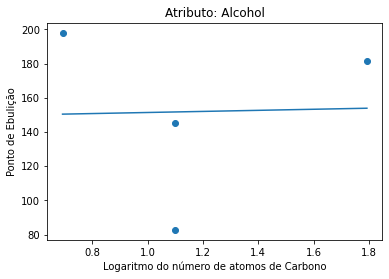

In [20]:
processar("orders.txt")